In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import glob
from PlanRecognition import find_colors
%matplotlib inline

# PLANS

In [3]:
def permutations(array, n=None, perm=[]):
    if n == None:
        n = len(array)
    if n == 0:
        yield perm
    else:
        for i in range(len(array)):
            yield from permutations(array[:i] + array[i + 1:], n - 1,
                                    perm + [array[i]])
def all_plans():
    yield from permutations(list(range(5)), 3)


PLANS = list(all_plans())
COLORS = np.array([[0, 124, 176], [208, 93, 40], [14, 14, 16], [97, 153, 59],
          [247, 181, 0]], dtype=np.uint8)
LABELS = ['blue', 'orange', 'black', 'green', 'yellow']

# Original colors

[[[ 99 255 176]
  [  9 206 208]
  [120  32  16]
  [ 48 157 153]
  [ 22 255 247]]]


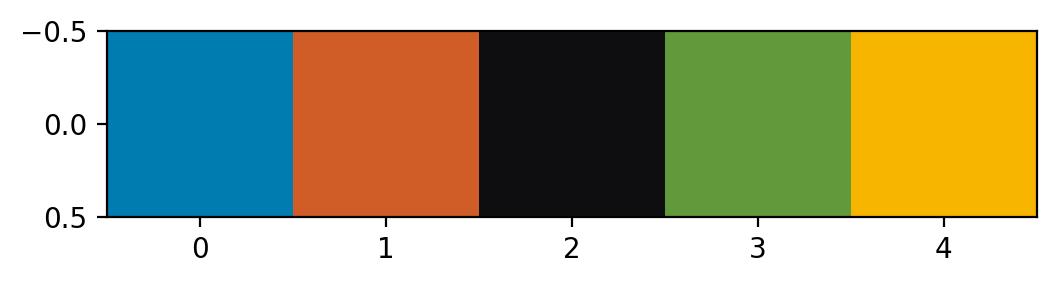

In [4]:
orig_colors_img = np.array([COLORS])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(orig_colors_img)
print(cv2.cvtColor(orig_colors_img, cv2.COLOR_RGB2HSV))

# Show image

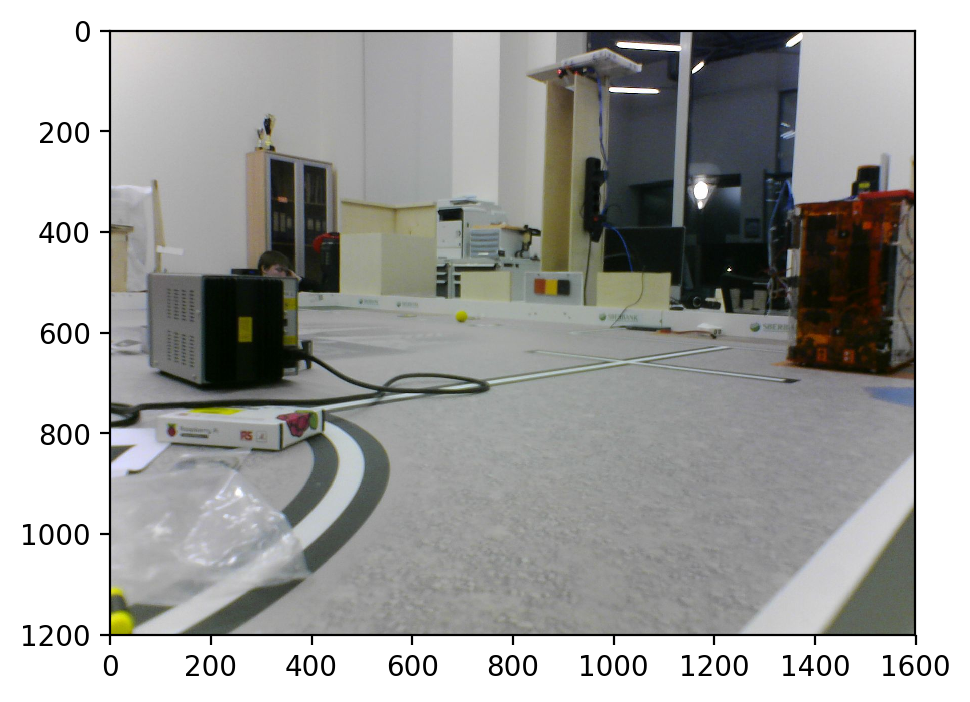

In [50]:
img = cv2.cvtColor(cv2.imread("imgs/142_1.png"), cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(img);

# Projection transformation using specific matrix

In [51]:
step = 30

In [52]:
img_points = np.float32([(798, 549), (798, 488), (912, 487), (912, 553)])
h_border = 3 * step * 2
w_border = 7 * step * 2
h_rect = int(130 / 30 * step)
w_rect = int(300 / 30 * step)
dw = (w_border - w_rect) / 2
dh = (h_border - h_rect) / 2
real_points = np.float32([(dw, h_border - dh), (dw, dh), 
                          (w_border - dw, dh), (w_border - dw, h_border - dh)])
M = cv2.getPerspectiveTransform(img_points, real_points)

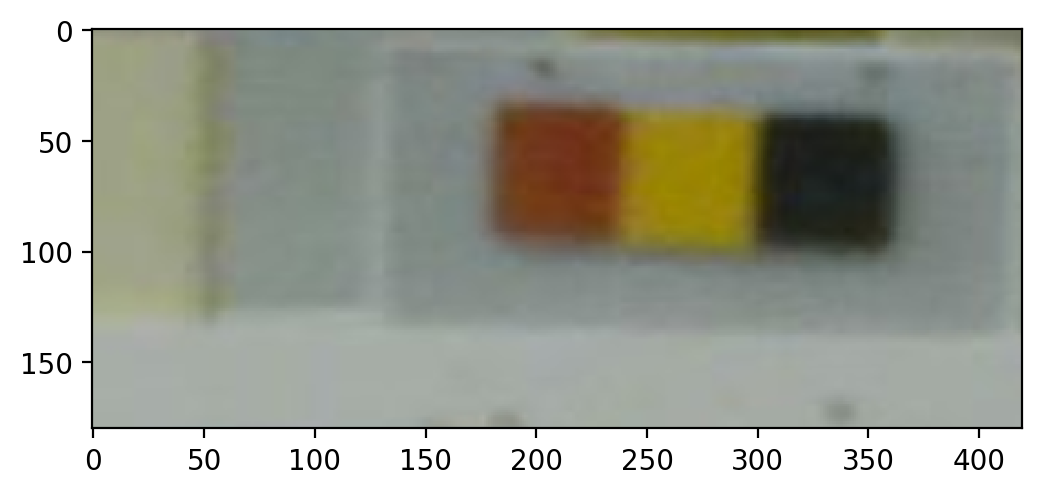

In [53]:
small_img = cv2.warpPerspective(img, M, (w_border, h_border))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(small_img);

# Image equalization

## Histogram

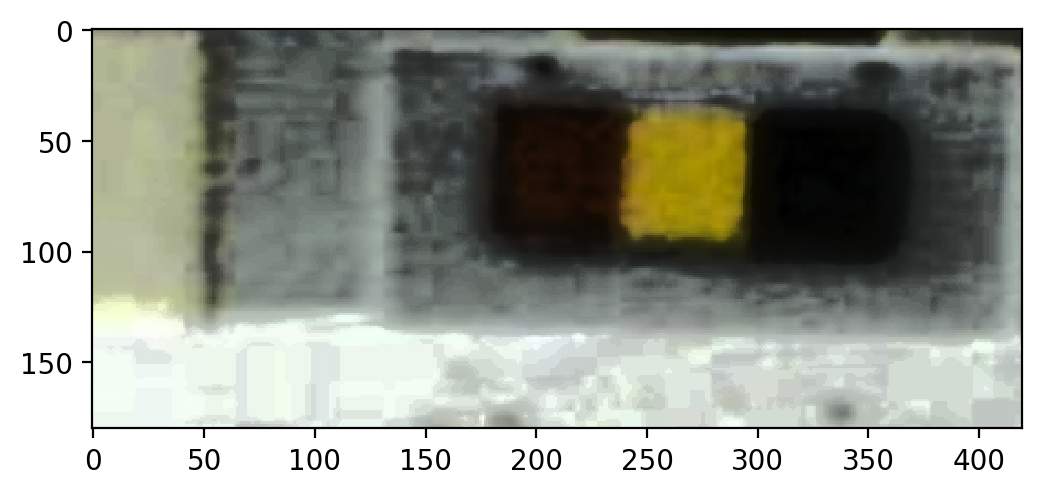

In [54]:
# hist_img = cv2.cvtColor(small_img, cv2.COLOR_RGB2YCrCb)
hist_img = cv2.cvtColor(small_img, cv2.COLOR_RGB2HSV)
hist_img[:, :, 2] = cv2.equalizeHist(hist_img[:, :, 2])
hist_img = cv2.cvtColor(hist_img, cv2.COLOR_HSV2RGB)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(hist_img);

## Clahe

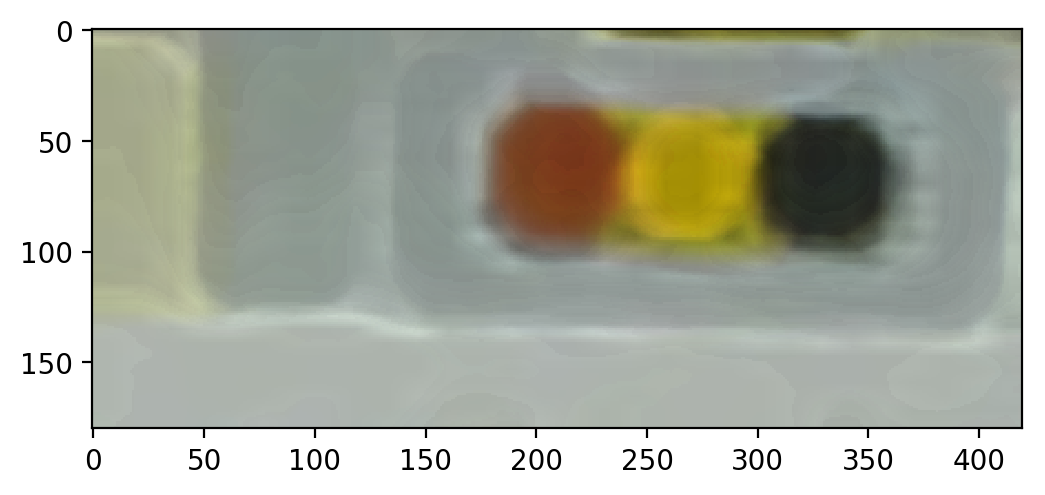

In [55]:
#img_1 = cv2.GaussianBlur(small_img,(13,13),10)
vl = int(step / 4)
img_1 = cv2.medianBlur(small_img, step + 1 + step % 2)
# img_1 = cv2.bilateralFilter(small_img, 60, 60, 24)
clh_img = cv2.cvtColor(img_1, cv2.COLOR_RGB2HSV)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(step, step))
clh_img[:, :, 2] = clahe.apply(clh_img[:, :, 2])
clh_img = cv2.cvtColor(clh_img, cv2.COLOR_HSV2RGB)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(clh_img);

# Rough image

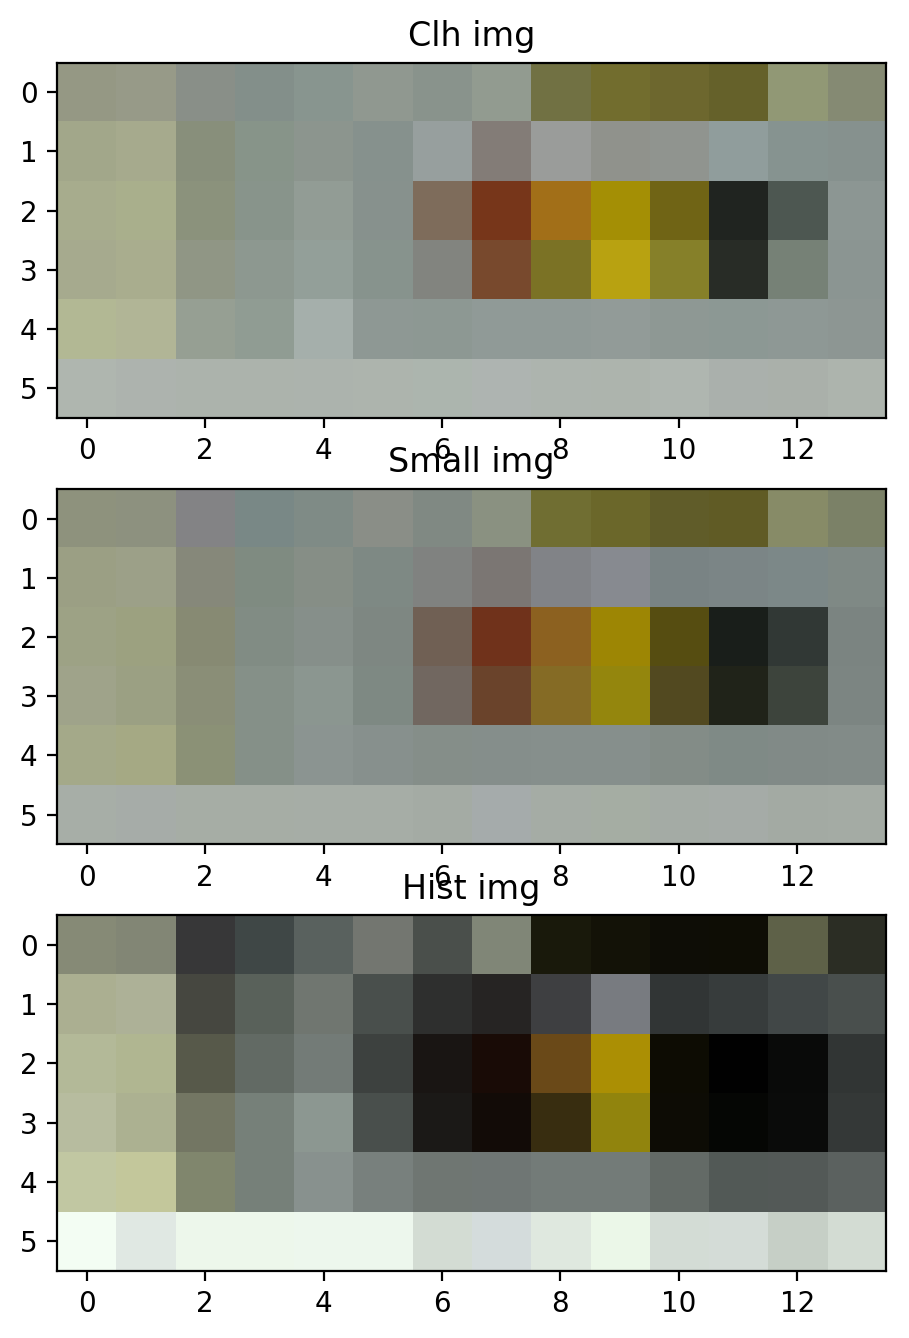

In [56]:
points1 = np.float32([(0, h_border), (0, 0), 
                       (w_border, 0)])
points2 = np.float32([(0, h_border // step), (0, 0), 
                       (w_border // step, 0)])

rough_img_1 = cv2.warpAffine(clh_img, cv2.getAffineTransform(points1, points2), 
                    (w_border // step, h_border // step))

rough_img_2 = cv2.warpAffine(small_img, cv2.getAffineTransform(points1, points2), 
                    (w_border // step, h_border // step))
rough_img_3 = cv2.warpAffine(hist_img, cv2.getAffineTransform(points1, points2), 
                    (w_border // step, h_border // step))
fig, ax = plt.subplots(3, 1, figsize=(6, 8), dpi=200)
ax[0].set_title("Clh img")
ax[0].imshow(rough_img_1)
ax[1].set_title("Small img")
ax[1].imshow(rough_img_2)
ax[2].set_title("Hist img")
ax[2].imshow(rough_img_3)

In [57]:
rough_img = rough_img_1

# Cube sequence searching

In [58]:
from colormath.color_diff import delta_e_cie2000, delta_e_cmc 
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color

def color_distance(c1, c2):
    color1 = sRGBColor(*c1, is_upscaled=True)
    lab_color1 = convert_color(color1, LabColor)
    color2 = sRGBColor(*c2, is_upscaled=True)
    lab_color2 = convert_color(color2, LabColor)
    return delta_e_cmc(lab_color1, lab_color2)

In [59]:
hight, width = rough_img.shape[0:2]
dist_array = np.zeros((hight, width, COLORS.shape[0]))

for i in range(COLORS.shape[0]):
    dist_array[:, :, i] = np.apply_along_axis(color_distance, 2, rough_img, COLORS[i])

plan_dist_array = np.zeros((hight, width - 4, len(PLANS)))

for i, plan in enumerate(PLANS):
    plan_dist_array[:, :, i] = sum([np.roll(dist_array[:, :, plan[x]]**2, -2 * x, axis=1)[:, :-4] for x in range(3)])

best_plan = np.unravel_index(np.argmin(plan_dist_array), (hight, width - 4, len(PLANS)))[2]
ind = np.unravel_index(np.argmin(plan_dist_array), (hight, width - 4, len(PLANS)))[0:2]

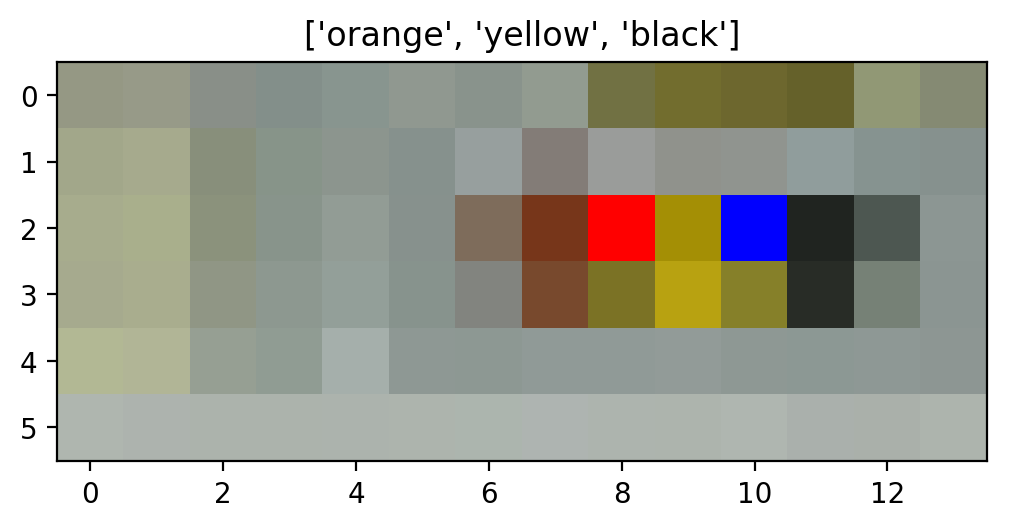

In [60]:
out_img = rough_img.copy()
out_img[ind[0], ind[1] + 1] = np.array([255, 0, 0])
out_img[ind[0], ind[1] + 3] = np.array([0, 0, 255])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.set_title([LABELS[PLANS[best_plan][x]] for x in range(3)])
ax.imshow(out_img);

# Projection transformation on images

In [20]:
files = glob.glob("imgs/*.png")
plans = [[LABELS[int(x_)] for x_ in x[5:8]] for x in files]

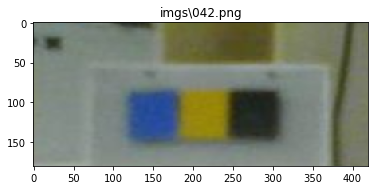

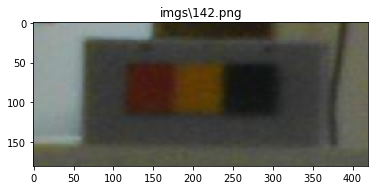

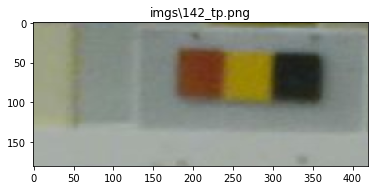

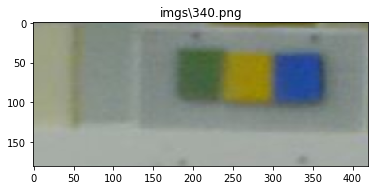

In [21]:
for file, plan in zip(files, plans):
    img_ = cv2.imread(file) 
    img_ = cv2.warpPerspective(img_, M, (w_border, h_border))

    plt.imshow(cv2.cvtColor(img_, cv2.COLOR_RGB2BGR))
    plt.title(file)
    plt.show()   

In [128]:
plt.title

'imgs\\432.png'

In [123]:
plt.title

'imgs\\432.png'

# Test on many images

In [18]:
files = glob.glob("imgs/*.png")
plans = [[int(x_) for x_ in x[5:8]] for x in files]
n_files = len(files)
n_errors = 0
for file, plan in zip(files, plans):
    img_ = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    found_plan = find_colors(img_, M, h_border, w_border)[0] 
    print(found_plan, plan, file)
    if found_plan != plan:
        print(False)
        n_errors += 1
print("Errors %d from %d" % (n_errors, n_files))

[0, 1, 2] [0, 1, 2] imgs\012.png
[0, 1, 2] [0, 1, 2] imgs\012_1.png
[0, 1, 2] [0, 1, 2] imgs\012_2.png
[0, 1, 3] [0, 1, 3] imgs\013.png
[0, 2, 3] [0, 2, 3] imgs\023.png
[0, 3, 1] [0, 3, 1] imgs\031.png
[0, 3, 1] [0, 3, 1] imgs\031_1.png
[0, 3, 4] [0, 3, 4] imgs\034.png
[0, 3, 4] [0, 3, 4] imgs\034_1.png
[0, 3, 4] [0, 3, 4] imgs\034_2.png
[0, 4, 3] [0, 4, 3] imgs\043.png
[1, 0, 3] [1, 0, 3] imgs\103.png
[1, 2, 3] [1, 2, 3] imgs\123.png
[1, 2, 3] [1, 2, 3] imgs\123_1.png
[1, 3, 4] [1, 3, 4] imgs\134.png
[1, 3, 4] [1, 3, 4] imgs\134_2.png
[1, 4, 0] [1, 4, 0] imgs\140.png
[1, 4, 0] [1, 4, 0] imgs\140_2.png
[2, 0, 3] [2, 0, 3] imgs\203.png
[2, 1, 3] [2, 1, 3] imgs\213.png
[2, 1, 3] [2, 1, 3] imgs\213_1.png
[2, 3, 1] [2, 3, 1] imgs\231.png
[2, 4, 1] [2, 4, 1] imgs\241.png
[3, 1, 4] [3, 1, 4] imgs\314.png
[3, 1, 4] [3, 1, 4] imgs\314_1.png
[3, 4, 0] [3, 4, 0] imgs\340.png
[4, 1, 3] [4, 1, 3] imgs\413.png
[4, 2, 0] [4, 2, 0] imgs\420.png
[4, 3, 1] [4, 3, 1] imgs\431.png
[4, 3, 2] [4, 3, 2] img

In [25]:
%%time
found_plan = find_colors(cv2.cvtColor(cv2.imread("imgs/432.png"), cv2.COLOR_BGR2RGB), M, h_border, w_border)[0]

Wall time: 397 ms
